### Project: Sustainable Development Goals (SDGs): Text Classification Challenge
----
#### Introduction

The aim is to classify text content by its relevance indicators of the United Nations’ Sustainable Development Goal #3 – Health and Well-Being (SDG 3). Each SDG has several “targets”, or social outcomes that the UN hopes to achieve by 2030.

The notebook contains the approach i use to classify relevent indicators.


### The road ahead:
- Importing relevant libraries
- The data
- Data Exploration
- Data Preprocessing
- Classification

### Importing Libraries:

In [34]:
#for data frames
import pandas as pd

# for algebra
import numpy as np

#for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# to handle text
import nltk

# for regular expresion
import re

# stopwords
from nltk.corpus import stopwords

# to stem the words
from nltk.stem.porter import PorterStemmer

# to automate the NLP extraction...
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# models to be build
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Cross validation
from sklearn.model_selection import cross_val_score

# Stack arrays in sequence horizontally (column wise)
from scipy.sparse import hstack

#Metrics
from sklearn import metrics

#Train test split
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
#Igonring warnings
import warnings
warnings.filterwarnings("ignore")

from ggplot import *

In [35]:
# Downloading stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## The Data

In [36]:
# Training data
train = pd.read_csv('Devex_train.csv',encoding='latin-1')

# Testing data
test = pd.read_csv('Devex_test_questions.csv',encoding='latin-1')

In [37]:
# Checking the fist 5 rows of training data set
train.head()

Unique ID          Type                                               Text  \
0      12555         Grant  Centers of Biomedical Research Excellence (COB...   
1      14108         Grant  Research on Regenerative Medicine <h2><strong>...   
2      23168  Organization  Catholic Health Association of India (CHAI): <...   
3     219512      Contract       Quality Improvement Initiatives for Diabetes   
4     274093        Tender  Provision of Thalassemia Drugs and Disposables...   

                                             Label 1  \
0  3.b.2 - Total net official development assista...   
1  3.b.2 - Total net official development assista...   
2  3.d.1 - International Health Regulations (IHR)...   
3  3.4.1 - Mortality rate attributed to cardiovas...   
4  3.3.5 - Number of people requiring interventio...   

                                             Label 2  \
0     3.c.1 - Health worker density and distribution   
1                                                NaN   
2  3.8.1 - Coverage of essential health services ...   
3                                                NaN   
4  3.4.1 - Mortality rate attributed to cardiovas...   

                                             Label 3  \
0                                                NaN   
1                                                NaN   
2  3.8.2 - Proportion of population with large ho...   
3                                                NaN   
4                                                NaN   

                                             Label 4 Label 5 Label 6 Label 7  \
0                                                NaN     NaN     NaN     NaN   
1                                                NaN     NaN     NaN     NaN   
2  3.b.3 - Proportion of health facilities that h...     NaN     NaN     NaN   
3                                                NaN     NaN     NaN     NaN   
4                                                NaN     NaN     NaN     NaN   

  Label 8 Label 9 Label 10  Label 11  Label 12  
0     NaN     NaN      NaN       NaN       NaN  
1     NaN     NaN      NaN       NaN       NaN  
2     NaN     NaN      NaN       NaN       NaN  
3     NaN     NaN      NaN       NaN       NaN  
4     NaN     NaN      NaN       NaN       NaN

In [38]:
# Checking the first 5 rows of the testing data sets
test.head()

Unique ID          Type                                               Text
0      49848  Organization  4th Sector Health: <p>4th Sector Health is a U...
1      52348  Organization  Action for Global Health: <p>Action for Global...
2     103541  Organization  Scottish Association for Mental Health (SAMH):...
3      52382  Organization  Singapore Immunology Network: <p>The Singapore...
4      47212  Organization  Coastal Conservation and Education Foundation ...

 ** Checking the format that we have to follow for submiting the predictions ** 

In [39]:
# Getting submision format
submit = pd.read_csv('Devex_submission_format.csv')

# Checking first 5 row of the submision format
submit.head()

ID  3.1.1  3.1.2  3.2.1  3.2.2  3.3.1  3.3.2  3.3.3  3.3.4  3.3.5  \
0  11437    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0   
1  11474    0.0    1.0    1.0    1.0    0.0    1.0    0.0    1.0    1.0   
2  11475    1.0    0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0   
3  11476    1.0    0.0    1.0    0.0    0.0    1.0    1.0    1.0    1.0   
4  11486    1.0    1.0    0.0    0.0    1.0    0.0    1.0    1.0    1.0   

   ...    3.8.2  3.9.1  3.9.2  3.9.3  3.a.1  3.b.1  3.b.2  3.b.3  3.c.1  3.d.1  
0  ...      0.0    0.0    0.0    1.0    1.0    0.0    0.0    0.0    1.0    0.0  
1  ...      0.0    1.0    1.0    0.0    1.0    0.0    0.0    1.0    0.0    1.0  
2  ...      0.0    1.0    0.0    0.0    1.0    1.0    0.0    1.0    0.0    1.0  
3  ...      1.0    0.0    1.0    0.0    1.0    1.0    0.0    1.0    1.0    1.0  
4  ...      0.0    0.0    1.0    0.0    1.0    0.0    1.0    0.0    0.0    1.0  

[5 rows x 28 columns]

### Data Exploreation

**The submission format only require Unique ID, and 27 labels. Now, i will convert the train data to a the following format: 
Unique ID, Type, Text, and all the labels**

- First i will start by converting data to Unique ID, Type, Text
- Then Create the dummy variables for all labels with relevant text, that is if a lavel belong to certain text, that label will be replaced with a 1 else 0.

In [40]:
# Initiate the label to loop through
labels = ['Label 1', 'Label 2', 'Label 3', 'Label 4',
          'Label 5', 'Label 6', 'Label 7', 'Label 8', 'Label 9', 'Label 10',
          'Label 11', 'Label 12']

# Create a new data frame in a new format
df = []
for i, row in train.iterrows():
    for label in row[labels]:
       df.append([row['Unique ID'],row['Type'],row['Text'],label])
df = pd.DataFrame(df,columns=['Unique ID', 'Type', 'Text','Label'])

In [41]:
# checking how the data look like
df.head()

Unique ID   Type                                               Text  \
0      12555  Grant  Centers of Biomedical Research Excellence (COB...   
1      12555  Grant  Centers of Biomedical Research Excellence (COB...   
2      12555  Grant  Centers of Biomedical Research Excellence (COB...   
3      12555  Grant  Centers of Biomedical Research Excellence (COB...   
4      12555  Grant  Centers of Biomedical Research Excellence (COB...   

                                               Label  
0  3.b.2 - Total net official development assista...  
1     3.c.1 - Health worker density and distribution  
2                                                NaN  
3                                                NaN  
4                                                NaN

In [42]:
#Removing the 'NaN' label
df.dropna(inplace=True)

In [43]:
#check the data
df.head()

Unique ID          Type  \
0       12555         Grant   
1       12555         Grant   
12      14108         Grant   
24      23168  Organization   
25      23168  Organization   

                                                 Text  \
0   Centers of Biomedical Research Excellence (COB...   
1   Centers of Biomedical Research Excellence (COB...   
12  Research on Regenerative Medicine <h2><strong>...   
24  Catholic Health Association of India (CHAI): <...   
25  Catholic Health Association of India (CHAI): <...   

                                                Label  
0   3.b.2 - Total net official development assista...  
1      3.c.1 - Health worker density and distribution  
12  3.b.2 - Total net official development assista...  
24  3.d.1 - International Health Regulations (IHR)...  
25  3.8.1 - Coverage of essential health services ...

** Creating label code column from label column **

In [44]:
# Label code column
df['Label_Code']=df['Label'].apply(lambda x: x.split('-')[0])
# Label column
df['Label']=df['Label'].apply(lambda x: x.split('-')[1])


In [45]:
# Reserting index and checking how the data look like
df = df.reset_index(drop=True)
df.head()

Unique ID          Type                                               Text  \
0      12555         Grant  Centers of Biomedical Research Excellence (COB...   
1      12555         Grant  Centers of Biomedical Research Excellence (COB...   
2      14108         Grant  Research on Regenerative Medicine <h2><strong>...   
3      23168  Organization  Catholic Health Association of India (CHAI): <...   
4      23168  Organization  Catholic Health Association of India (CHAI): <...   

                                               Label Label_Code  
0   Total net official development assistance to ...     3.b.2   
1             Health worker density and distribution     3.c.1   
2   Total net official development assistance to ...     3.b.2   
3   International Health Regulations (IHR) capaci...     3.d.1   
4   Coverage of essential health services (define...     3.8.1

In [46]:
#Creating a dummy variable and converting each unique label code to a column
df=pd.get_dummies(data=df,columns=['Label_Code'])


In [47]:
#Grouping relevent code to relevent text
df= df.groupby(['Unique ID','Type','Text']).sum().reset_index()
df.head()

Unique ID      Type                                               Text  \
0        719  Open Opp  Improving Quality and Safety of Care: <p><stro...   
1        728  Open Opp  Support for Philanthropy, Child Health, Empowe...   
2        732  Open Opp  Provision of Clinical Trial to Reduce Health I...   
3        739  Open Opp  Provision of Treatment Innovations for Poverty...   
4        740  Open Opp  Ethical, Legal, and Social Implications (ELSI)...   

   Label_Code_3.1.1   Label_Code_3.1.2   Label_Code_3.2.1   Label_Code_3.2.2   \
0                  0                  0                  0                  0   
1                  0                  0                  1                  1   
2                  1                  0                  1                  1   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   Label_Code_3.3.1   Label_Code_3.3.2   Label_Code_3.3.3         ...          \
0                  0                  0                  0        ...           
1                  0                  0                  0        ...           
2                  0                  0                  0        ...           
3                  1                  1                  1        ...           
4                  0                  0                  0        ...           

   Label_Code_3.8.2   Label_Code_3.9.1   Label_Code_3.9.2   Label_Code_3.9.3   \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  1                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   Label_Code_3.a.1   Label_Code_3.b.1   Label_Code_3.b.2   Label_Code_3.b.3   \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  1   
3                  0                  0                  0                  0   
4                  0                  0                  1                  0   

   Label_Code_3.c.1   Label_Code_3.d.1   
0                  1                  0  
1                  0                  0  
2                  0                  0  
3                  0                  0  
4                  0                  0  

[5 rows x 30 columns]

In [48]:
#relabelling the columns
df.columns = ['Unique ID', 'Type','Text', '3.1.1 ', '3.1.2 ','3.2.1 ', '3.2.2 ', '3.3.1 ',
       '3.3.2 ', '3.3.3 ', '3.3.4 ','3.3.5 ', '3.4.1 ', '3.4.2 ',
       '3.5.1 ', '3.5.2 ', '3.6.1 ','3.7.1 ', '3.7.2 ', '3.8.1 ',
       '3.8.2 ', '3.9.1 ', '3.9.2 ','3.9.3 ', '3.a.1 ', '3.b.1 ',
       '3.b.2 ', '3.b.3 ', '3.c.1 ','3.d.1 ']

In [49]:
# Checking number of rows and columns of the data sets
print("Number of rows in data =",df.shape[0])
print("Number of columns in data =",df.shape[1])
print("\n")
print("**Sample data:**")
df.head()

Number of rows in data = 2994
Number of columns in data = 30


**Sample data:**


Unique ID      Type                                               Text  \
0        719  Open Opp  Improving Quality and Safety of Care: <p><stro...   
1        728  Open Opp  Support for Philanthropy, Child Health, Empowe...   
2        732  Open Opp  Provision of Clinical Trial to Reduce Health I...   
3        739  Open Opp  Provision of Treatment Innovations for Poverty...   
4        740  Open Opp  Ethical, Legal, and Social Implications (ELSI)...   

   3.1.1   3.1.2   3.2.1   3.2.2   3.3.1   3.3.2   3.3.3    ...    3.8.2   \
0       0       0       0       0       0       0       0   ...         0   
1       0       0       1       1       0       0       0   ...         0   
2       1       0       1       1       0       0       0   ...         1   
3       0       0       0       0       1       1       1   ...         0   
4       0       0       0       0       0       0       0   ...         0   

   3.9.1   3.9.2   3.9.3   3.a.1   3.b.1   3.b.2   3.b.3   3.c.1   3.d.1   
0       0       0       0       0       0       0       0       1       0  
1       0       0       0       0       0       0       0       0       0  
2       0       0       0       0       0       0       1       0       0  
3       0       0       0       0       0       0       0       0       0  
4       0       0       0       0       0       1       0       0       0  

[5 rows x 30 columns]

### Visualising text using wordclouds

In [50]:
# Creating a wordcloud function to visualize the most 2000 used words
def word_cloud(axes,text,width=400, height=200,max_words=2000,background_color='white'):
    """
    Visualise a word clouds
    --------------------
    Parameters:
    -------
    axes             : axes of the word cloud vusialisation
    text             : text data 
    width            : width of the axes, default 400 
    height           : height of the axes, default 200
    max_words        : maximum words to distplay, defaulf 500
    background_color : defaulf white
    
    """
    #Create and generate a wordclod image
    wordcloud = WordCloud(max_words=max_words,background_color=background_color).generate(str(text))
    
    # show a word cloud image
    g = axes.imshow(wordcloud) 
    
    #Remove axes label
    axes.axis('off')
    return g

** Train data**

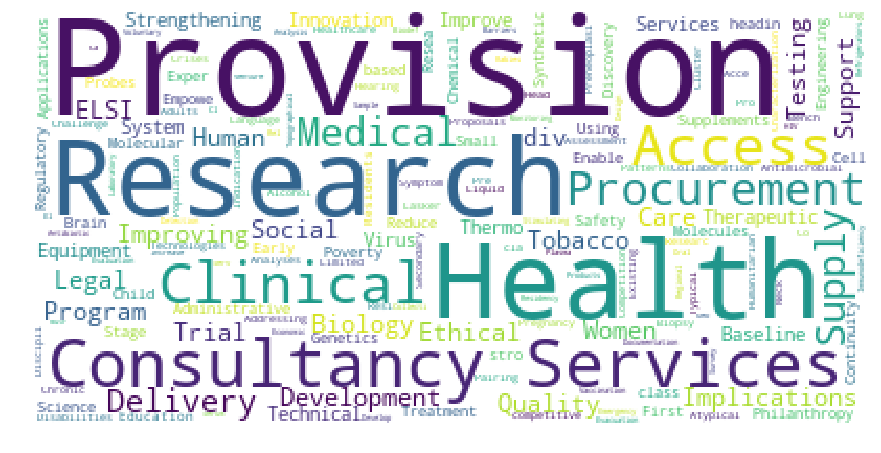

In [51]:
fig, axes = plt.subplots(figsize=(15,10))
word_cloud(axes,df['Text'],background_color='white')
plt.show()

** Test Data **

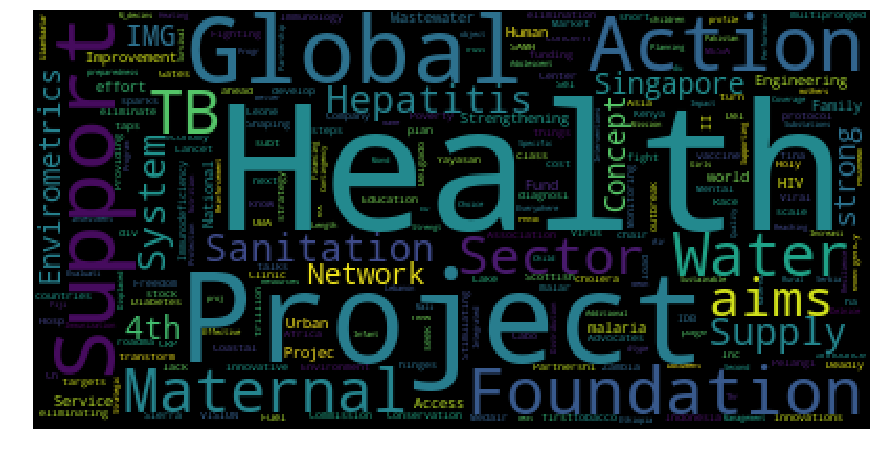

In [52]:
fig, axes = plt.subplots(figsize=(15,10))
word_cld=word_cloud(axes,test['Text'],background_color='black')
plt.show()

** A bar graph that shows which 'Type' contributed more text, both for train and test data**

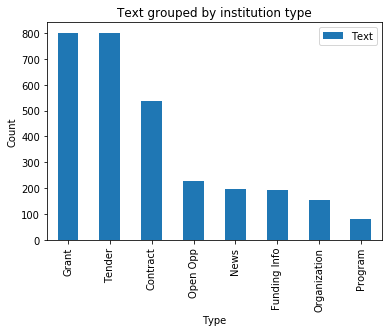

In [53]:
#Train data
fig = plt.figure(figsize=(13,8))
dtt = df.groupby('Type').count()['Text'].reset_index().sort_values(by='Text',ascending=False).plot(x='Type',kind='bar')
plt.title('Text grouped by institution type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

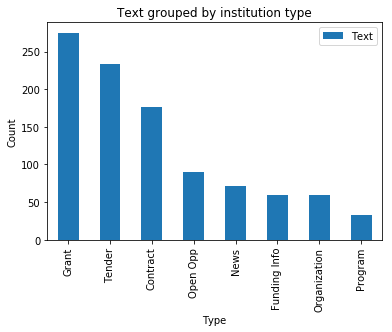

In [54]:
# Test data
fig = plt.figure(figsize=(13,8))
test.groupby('Type').count()['Text'].reset_index().sort_values(by='Text',ascending=False).plot(x='Type',kind='bar')
plt.title('Text grouped by institution type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

### Data Preprocesing

- Cleaning the data: Removing unwanted characters,punctuations and numbers within text
- Removing stopwords
- Stemming the words
- Use TfidfVectorizer for Feature Selection/Extration

#### Cleaning data

In [55]:
#Removing unwanted charachters in both testing and training data
df['Text']=df['Text'].apply(lambda x:re.sub('[^a-zA-Z]',' ', str(x)))
test['Text']=test['Text'].apply(lambda x:re.sub('[^a-zA-Z]',' ', str(x)))

In [56]:
# Making text lower case
df['Text'] = df['Text'].str.lower()
test['Text'] = test['Text'].str.lower()

In [57]:
#remove punctuation
import string
def remove_punctuation_numbers(text):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in text if l not in punc_numbers])
df['Text'] = df['Text'].apply(remove_punctuation_numbers)
test['Text'] = test['Text'].apply(remove_punctuation_numbers)

In [58]:
#removing stopwords
def remove_stopwords(text):
    stopwords_ = set(stopwords.words('english')+ ['em','toc','p','ol','ul','li','ii','i','iii','h','br'])
    return ' '.join([words for words in text.split() if words not in stopwords_ ])

df['Text'] = df['Text'].apply(remove_stopwords)
test['Text'] = test['Text'].apply(remove_stopwords)

In [59]:
#Stemming the words, using PorterStemmer:
def stem_words(text): 
    st = PorterStemmer() 
    return ' '.join([st.stem(words) for words in text.split()]) 
df['Text'] = df['Text'].apply(stem_words)
test['Text'] = test['Text'].apply(stem_words)

In [60]:
print('Number of missing text in text:')
df['Text'].isnull().sum()

Number of missing text in text:


0

#### Text distribution

Text(0.5,1,'Test text distribution')

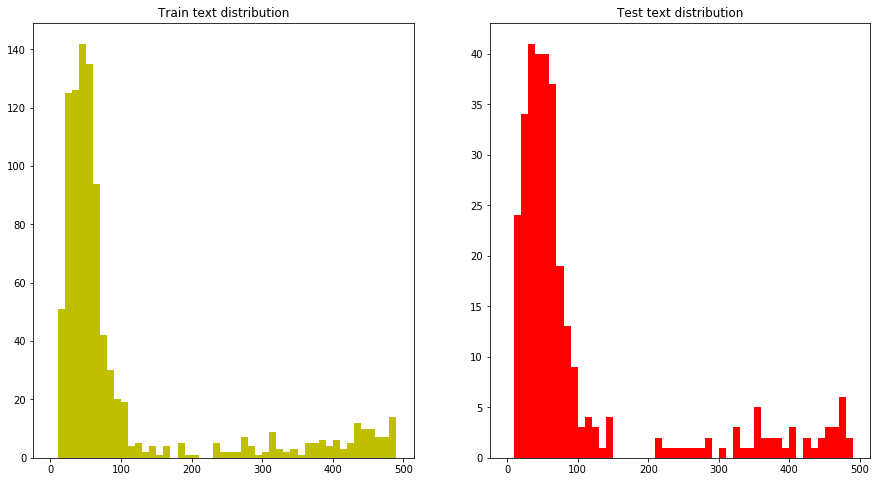

In [61]:
lens = df['Text'].str.len()
lens1 = test['Text'].str.len()
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(15,8))
axes1.hist(x=lens,bins = np.arange(0,500,10),color='y')
axes1.set_title('Train text distribution')
axes2.hist(x=lens1,bins = np.arange(0,500,10),color='r')
axes2.set_title('Test text distribution')

> ** On average, a text consist of around +/- 100 words **

#### A bar graph to Visualize labels\Categories. 

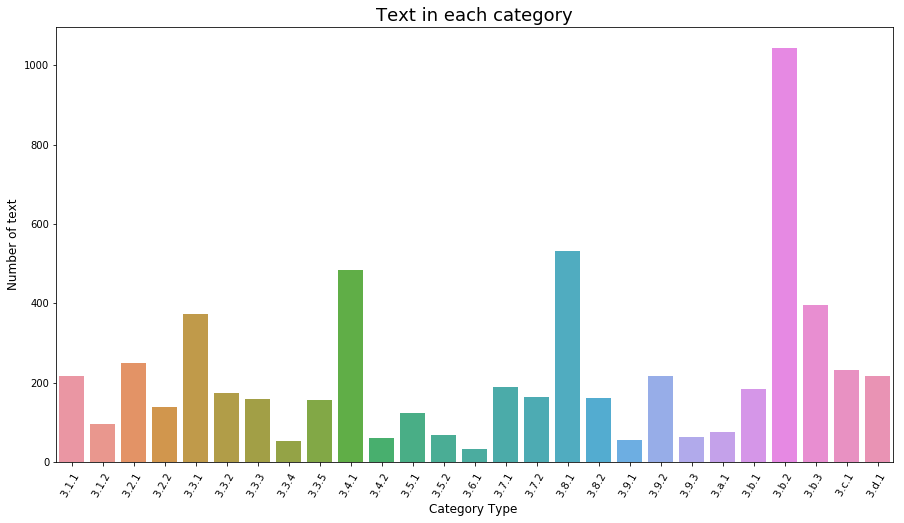

In [62]:
categories = ['3.1.1 ', '3.1.2 ', '3.2.1 ', '3.2.2 ',
       '3.3.1 ', '3.3.2 ', '3.3.3 ', '3.3.4 ', '3.3.5 ', '3.4.1 ', '3.4.2 ',
       '3.5.1 ', '3.5.2 ', '3.6.1 ', '3.7.1 ', '3.7.2 ', '3.8.1 ', '3.8.2 ',
       '3.9.1 ', '3.9.2 ', '3.9.3 ', '3.a.1 ', '3.b.1 ', '3.b.2 ', '3.b.3 ',
       '3.c.1 ', '3.d.1 ']

plt.figure(figsize=(15,8))
ax= sns.barplot(categories, df.iloc[:,3:].sum().values)
plt.title("Text in each category", fontsize=18)
plt.ylabel('Number of text', fontsize=12)
plt.xlabel('Category Type ', fontsize=12)
plt.xticks(rotation=60)
plt.show()

> ** There seems to be a lots of category imbalnce, with 3.b.2 highest**

### A bar graph to show category class imbalance

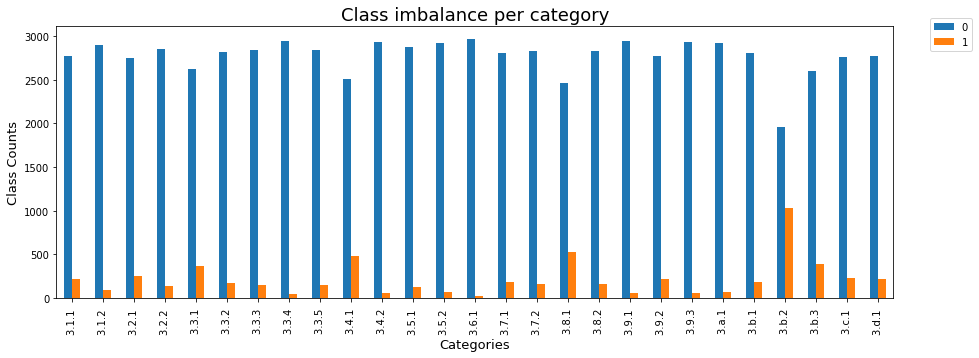

In [63]:
classes_imbalabce = pd.DataFrame({})
for i in categories:
    classes_imbalabce[i] = df[i].value_counts()

classes_imbalabce.T.plot(kind='bar',figsize=(15,5))
plt.title('Class imbalance per category',fontsize=18)
plt.ylabel('Class Counts',fontsize=13)
plt.xlabel('Categories',fontsize=13)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

> ** Class 0 has dominated in all categories **

#### Feature selection/ Engineering


> - Hashstaking words and characher n-grams. ** For the following part, i follow this**: https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams.


#### Hashstacking words and characters

In [64]:
#Tacking the text data
df_text = df['Text']
#Combining the data
all_data =pd.concat([df['Text'],test['Text']])
word_vectorizer = TfidfVectorizer( sublinear_tf=True,
                                  strip_accents='unicode',
                                  analyzer='word',
                                  token_pattern=r'\w{1,}',
                                  stop_words='english',
                                  ngram_range=(1, 1),
                                  max_features=1000)
word_vectorizer.fit(all_data)
df_word_features = word_vectorizer.transform(df_text) 
df_word_pred_features = word_vectorizer.transform(test['Text']) 

char_vectorizer = TfidfVectorizer( sublinear_tf=True,
                                  strip_accents='unicode', 
                                  analyzer='char',
                                  stop_words='english',
                                  ngram_range=(2, 10),
                                  max_features=3000) 
char_vectorizer.fit(all_data)
df_char_features =char_vectorizer.fit_transform(df_text)
df_char_pred_features =char_vectorizer.fit_transform(test['Text'])


X_ht = hstack([df_char_features, df_word_features])
X_ht_pred = hstack([df_char_pred_features,df_word_pred_features])



#checking hastached data
data_ht=pd.DataFrame(X_ht.A)
data_ht.head()

0         1         2         3         4         5         6     \
0  0.033715  0.026809  0.031487  0.035991  0.000000  0.000000  0.000000   
1  0.035485  0.022988  0.000000  0.000000  0.029357  0.030284  0.031933   
2  0.025686  0.019501  0.016395  0.013296  0.018648  0.017592  0.016313   
3  0.026310  0.020313  0.015018  0.008180  0.021928  0.021437  0.021128   
4  0.021773  0.015819  0.014543  0.016623  0.013833  0.005980  0.006306   

       7         8         9     ...       3990  3991      3992  3993  \
0  0.000000  0.009641  0.011514  ...   0.140819   0.0  0.216389   0.0   
1  0.032200  0.015035  0.017957  ...   0.000000   0.0  0.000000   0.0   
2  0.016450  0.022091  0.015532  ...   0.062345   0.0  0.000000   0.0   
3  0.021305  0.021317  0.013053  ...   0.064979   0.0  0.000000   0.0   
4  0.006358  0.018293  0.019828  ...   0.000000   0.0  0.000000   0.0   

       3994      3995  3996     3997  3998  3999  
0  0.000000  0.000000   0.0  0.06296   0.0   0.0  
1  0.000000  0.000000   0.0  0.00000   0.0   0.0  
2  0.000000  0.079464   0.0  0.00000   0.0   0.0  
3  0.032163  0.075739   0.0  0.00000   0.0   0.0  
4  0.000000  0.042512   0.0  0.04839   0.0   0.0  

[5 rows x 4000 columns]

### Building the model
**I will train the following two models **
- Logistics regression
- Randomforest classification


In [65]:
def build_model(X,y,X_pred,classifier):
    
    class_names = categories
    submission = pd.DataFrame.from_dict({'Unique ID': test['Unique ID']})
    
    scores = []
    for category in categories:
        print('Processing category {}'.format(category))
        
        X =X
        y_ = y[category]
        
        # Cross validation
        cv_score = np.mean(cross_val_score(classifier, X, y_, cv=20))
        scores.append(cv_score)
        
        # train the model using X_dtm & y
        classifier.fit(X, y_)
        
        
        # compute the testing accuracy
        prediction = classifier.predict(X_pred)
        
        # submission
        submission[category]= classifier.predict(X_pred)

    submission.to_csv('submission3.csv', index=False)

    print('Averall cross_validation score {}'.format(np.mean(scores)))
    return submission.head()
 

### Logistic regression

In [66]:
y=df[categories]
X = X_ht
X_pred = X_ht_pred
classifier = LogisticRegression(C=0.1,solver='sag')
build_model(X,y,X_pred,classifier)

Processing category 3.1.1 
Processing category 3.1.2 
Processing category 3.2.1 
Processing category 3.2.2 
Processing category 3.3.1 
Processing category 3.3.2 
Processing category 3.3.3 
Processing category 3.3.4 
Processing category 3.3.5 
Processing category 3.4.1 
Processing category 3.4.2 
Processing category 3.5.1 
Processing category 3.5.2 
Processing category 3.6.1 
Processing category 3.7.1 
Processing category 3.7.2 
Processing category 3.8.1 
Processing category 3.8.2 
Processing category 3.9.1 
Processing category 3.9.2 
Processing category 3.9.3 
Processing category 3.a.1 
Processing category 3.b.1 
Processing category 3.b.2 
Processing category 3.b.3 
Processing category 3.c.1 
Processing category 3.d.1 
Averall cross_validation score 0.9353210279800628


Unique ID  3.1.1   3.1.2   3.2.1   3.2.2   3.3.1   3.3.2   3.3.3   3.3.4   \
0      49848       0       0       0       0       0       0       0       0   
1      52348       0       0       0       0       0       0       0       0   
2     103541       0       0       0       0       0       0       0       0   
3      52382       0       0       0       0       0       0       0       0   
4      47212       0       0       0       0       0       0       0       0   

   3.3.5    ...    3.8.2   3.9.1   3.9.2   3.9.3   3.a.1   3.b.1   3.b.2   \
0       0   ...         0       0       0       0       0       0       0   
1       0   ...         0       0       0       0       0       0       0   
2       0   ...         0       0       0       0       0       0       0   
3       0   ...         0       0       0       0       0       0       0   
4       0   ...         0       0       0       0       0       0       0   

   3.b.3   3.c.1   3.d.1   
0       0       0       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0  

[5 rows x 28 columns]

### RandomForest classifier

In [67]:
y=df[categories]
X = X_ht
X_pred = X_ht_pred
classifier = RandomForestClassifier()
build_model(X,y,X_pred,classifier)

Processing category 3.1.1 
Processing category 3.1.2 
Processing category 3.2.1 
Processing category 3.2.2 
Processing category 3.3.1 
Processing category 3.3.2 
Processing category 3.3.3 
Processing category 3.3.4 
Processing category 3.3.5 
Processing category 3.4.1 
Processing category 3.4.2 
Processing category 3.5.1 
Processing category 3.5.2 
Processing category 3.6.1 
Processing category 3.7.1 
Processing category 3.7.2 
Processing category 3.8.1 
Processing category 3.8.2 
Processing category 3.9.1 
Processing category 3.9.2 
Processing category 3.9.3 
Processing category 3.a.1 
Processing category 3.b.1 
Processing category 3.b.2 
Processing category 3.b.3 
Processing category 3.c.1 
Processing category 3.d.1 
Averall cross_validation score 0.9393889743951507


Unique ID  3.1.1   3.1.2   3.2.1   3.2.2   3.3.1   3.3.2   3.3.3   3.3.4   \
0      49848       0       0       0       0       0       0       0       0   
1      52348       0       0       0       0       0       0       0       0   
2     103541       0       0       0       0       0       0       0       0   
3      52382       0       0       0       0       0       0       0       0   
4      47212       0       0       0       0       0       0       0       0   

   3.3.5    ...    3.8.2   3.9.1   3.9.2   3.9.3   3.a.1   3.b.1   3.b.2   \
0       0   ...         0       0       0       0       0       0       0   
1       0   ...         0       0       0       0       0       0       0   
2       0   ...         0       0       0       0       0       0       1   
3       0   ...         0       0       0       0       0       0       0   
4       0   ...         0       0       0       0       0       0       1   

   3.b.3   3.c.1   3.d.1   
0       0       0       0  
1       0       0       0  
2       0       1       0  
3       0       0       0  
4       0       0       0  

[5 rows x 28 columns]

# Now i will train models on a balanced data

### Balancing the data by Up sampling minority class.

 - Up-sampling is the process of randomly duplicating observations from the minority class
 - There are many different ways of doing this, but i will simply use resample without replacement
 

In [68]:
df.columns

Index(['Unique ID', 'Type', 'Text', '3.1.1 ', '3.1.2 ', '3.2.1 ', '3.2.2 ',
       '3.3.1 ', '3.3.2 ', '3.3.3 ', '3.3.4 ', '3.3.5 ', '3.4.1 ', '3.4.2 ',
       '3.5.1 ', '3.5.2 ', '3.6.1 ', '3.7.1 ', '3.7.2 ', '3.8.1 ', '3.8.2 ',
       '3.9.1 ', '3.9.2 ', '3.9.3 ', '3.a.1 ', '3.b.1 ', '3.b.2 ', '3.b.3 ',
       '3.c.1 ', '3.d.1 '],
      dtype='object')

In [69]:
#Importing resmple module from SKlearn
from sklearn.utils import resample

#### Up sampling minority class, in this case class 1.

In [70]:
balanced_data = ({})
class_counts = pd.DataFrame({})
for i in categories:
    
    # Separate majority and minority classes
    df_majority = df[df[i]==0]
    df_minority = df[df[i]==1]
    n= len(df_majority)
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=n,    # to match majority class
                                     random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    #save to as a dictionary
    balanced_data[i] =df_upsampled[['Unique ID', 'Type', 'Text',i]]
    
    # Display new class counts
    class_counts[i]= df_upsampled[i].value_counts()


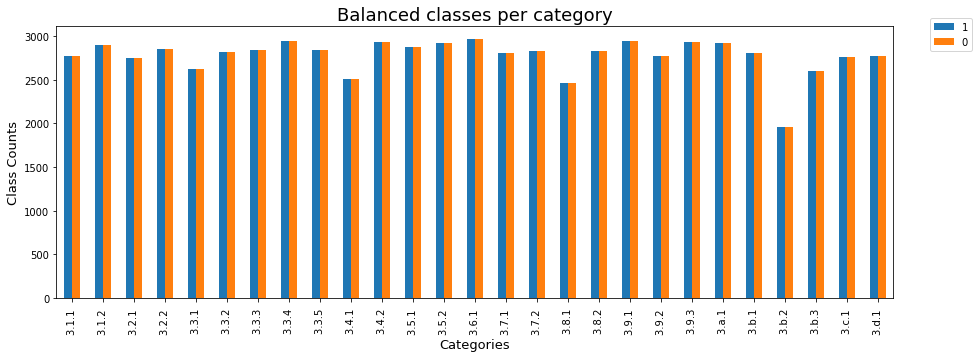

In [71]:
class_counts.T.plot(kind='bar',figsize=(15,5))
plt.title('Balanced classes per category',fontsize=18)
plt.ylabel('Class Counts',fontsize=13)
plt.xlabel('Categories',fontsize=13)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [72]:
#Let's view categiry 3.1.1 data
balanced_data['3.1.1 '].head()

Unique ID      Type                                               Text  \
0        719  Open Opp  improv qualiti safeti care strong opportun bac...   
1        728  Open Opp  support philanthropi child health empower nutr...   
3        739  Open Opp  provis treatment innov poverti relat diseas st...   
4        740  Open Opp  ethic legal social implic elsi genom research ...   
5        746  Open Opp  provis clinic research develop fellowship gpn ...   

   3.1.1   
0       0  
1       0  
3       0  
4       0  
5       0

### Building the model
**I will train the following two models **
- Logistics regression
- Randomforest classification

In [92]:

def run_model_balanced_df(df_balanced,X_prd,classifier):    
    class_names = categories
    submission = pd.DataFrame.from_dict({'Unique ID': test['Unique ID']})
    
    scores = []
    for category in categories:
        
        df_ =df_balanced[category]
        X = df_['Text']
        y_ = df_[category]
        
        #Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.20, random_state=42)
        
        #Combining the data
        all_data =pd.concat([X_train,X_test])
                             
        #Feature selection                     
        Tfidf_Vectorizer = TfidfVectorizer( sublinear_tf=True,
                                           strip_accents='unicode',
                                           analyzer='word',
                                           token_pattern=r'\w{1,}',
                                           stop_words='english',
                                           ngram_range=(1, 1),
                                           max_features=500)
        Tfidf_Vectorizer.fit(all_data)
        df_word_features = Tfidf_Vectorizer.transform(X) 
        df_words_test_features= Tfidf_Vectorizer.transform(X_test)
        df_word_pred_features = Tfidf_Vectorizer.transform(X_prd) 
        
        # train the model using X_dtm & y
        classifier.fit(df_word_features, y_)
        
        # Cross validation
        prediction=classifier.predict(df_words_test_features)
        accuracy= metrics.accuracy_score(y_test,prediction)
        scores.append(accuracy)
        print('Processing category {}'.format(category))
        print('')
        
        
        # submission
        submission[category]= classifier.predict(df_word_pred_features)


    submission.to_csv('submission4.csv', index=False)
    print('Averall Acuracy {}'.format(np.mean(accuracy)))
    return submission.head()

### Logistic regression

In [93]:
classifier = LogisticRegression()
data = balanced_data
X_prd = test['Text']
run_model_balanced_df(data,X_prd,classifier)


Processing category 3.1.1 

Processing category 3.1.2 

Processing category 3.2.1 

Processing category 3.2.2 

Processing category 3.3.1 

Processing category 3.3.2 

Processing category 3.3.3 

Processing category 3.3.4 

Processing category 3.3.5 

Processing category 3.4.1 

Processing category 3.4.2 

Processing category 3.5.1 

Processing category 3.5.2 

Processing category 3.6.1 

Processing category 3.7.1 

Processing category 3.7.2 

Processing category 3.8.1 

Processing category 3.8.2 

Processing category 3.9.1 

Processing category 3.9.2 

Processing category 3.9.3 

Processing category 3.a.1 

Processing category 3.b.1 

Processing category 3.b.2 

Processing category 3.b.3 

Processing category 3.c.1 

Processing category 3.d.1 

Averall Acuracy 0.9450945094509451


Unique ID  3.1.1   3.1.2   3.2.1   3.2.2   3.3.1   3.3.2   3.3.3   3.3.4   \
0      49848       1       0       0       0       1       0       0       0   
1      52348       0       0       0       0       1       0       1       0   
2     103541       0       0       0       0       0       0       0       0   
3      52382       0       0       0       0       0       0       0       0   
4      47212       0       0       0       0       0       0       0       0   

   3.3.5    ...    3.8.2   3.9.1   3.9.2   3.9.3   3.a.1   3.b.1   3.b.2   \
0       0   ...         0       0       0       0       0       0       0   
1       1   ...         1       0       0       0       0       0       0   
2       0   ...         0       0       0       0       0       0       0   
3       0   ...         0       0       0       0       0       0       1   
4       0   ...         0       1       1       1       0       0       0   

   3.b.3   3.c.1   3.d.1   
0       0       0       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       1       0  

[5 rows x 28 columns]

### Random Forest classifier

In [94]:
classifier = RandomForestClassifier()
data = balanced_data
X_prd = test['Text']
run_model_balanced_df(data,X_prd,classifier)

Processing category 3.1.1 

Processing category 3.1.2 

Processing category 3.2.1 

Processing category 3.2.2 

Processing category 3.3.1 

Processing category 3.3.2 

Processing category 3.3.3 

Processing category 3.3.4 

Processing category 3.3.5 

Processing category 3.4.1 

Processing category 3.4.2 

Processing category 3.5.1 

Processing category 3.5.2 

Processing category 3.6.1 

Processing category 3.7.1 

Processing category 3.7.2 

Processing category 3.8.1 

Processing category 3.8.2 

Processing category 3.9.1 

Processing category 3.9.2 

Processing category 3.9.3 

Processing category 3.a.1 

Processing category 3.b.1 

Processing category 3.b.2 

Processing category 3.b.3 

Processing category 3.c.1 

Processing category 3.d.1 

Averall Acuracy 1.0


Unique ID  3.1.1   3.1.2   3.2.1   3.2.2   3.3.1   3.3.2   3.3.3   3.3.4   \
0      49848       0       0       0       0       0       0       0       0   
1      52348       0       0       0       0       1       0       0       0   
2     103541       0       0       0       0       0       0       0       0   
3      52382       0       0       0       0       0       0       0       0   
4      47212       0       0       0       0       0       0       0       0   

   3.3.5    ...    3.8.2   3.9.1   3.9.2   3.9.3   3.a.1   3.b.1   3.b.2   \
0       0   ...         0       0       0       0       0       0       0   
1       0   ...         0       0       0       0       0       0       0   
2       0   ...         0       0       0       0       0       0       0   
3       0   ...         0       0       0       0       0       0       1   
4       0   ...         0       0       0       0       0       0       0   

   3.b.3   3.c.1   3.d.1   
0       0       0       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0  

[5 rows x 28 columns]

**Wow, Random forest seems to be doing a great job! on balanced data**.